Classification via Gaussian Naive Bayes and Multilayer Perceptron


### Basic environment setup

In [193]:
# Basic setup
import numpy as np
import torch
from torch import nn
import os
from sklearn.datasets import load_iris
np.set_printoptions(precision=3)

# set the seed for the random number generator
np.random.seed(seed=3314)
torch.manual_seed(3314)
# matplotlib is used to plot/visualize things
import matplotlib.pyplot as plt # import matplotlib.pyplot for plotting figures
plt.style.use('ggplot') # use "ggplot" style for graphs
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(3314)
    torch.cuda.manual_seed_all(3314)
    
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

#device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

### Loading the well-known Iris dataset


In [194]:
# loading the iris dataset
iris = load_iris()
# print the basic information about the dataset
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### Visualizing the Iris dataset

X shape: (150, 4)
y shape: (150,)


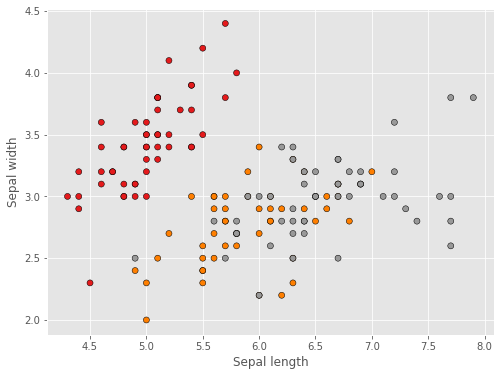

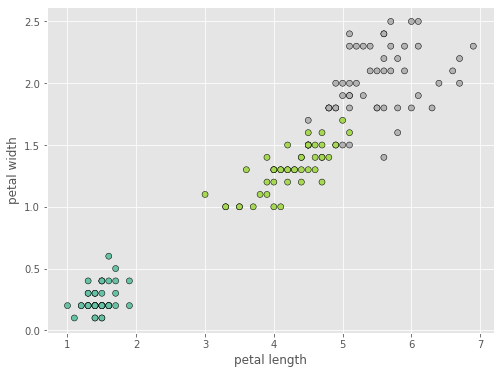

In [195]:
# read the features and the labels
X = iris.data
y = iris.target

# print the shape of the features and the labels
print("X shape:", X.shape)
print("y shape:", y.shape)

# visualize the features
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 2], X[:, 3], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

#### Splitting the Iris dataset

In [196]:
test_data_index = np.linspace(0, 149, 30, dtype=int)
train_data_index = np.setdiff1d(np.arange(150), test_data_index)
x_test, y_test = X[test_data_index], y[test_data_index]
x_train, y_train = X[train_data_index], y[train_data_index]

num_classes = 3 # the number of classes
D = 4 # the number of features, namely the dimension of the data

# plt.figure(figsize=(8, 6))
# plt.plot(y_train, 'o', c='b', label='train')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(y_test, 'o', c='r', label='test')
# plt.show()

---

## Section 1: Gaussian Naive Bayes Classifier


### 1. Gaussian distribution

#### 1.1 Univairate Gaussian distribution
The probability density function (pdf) of a univariate Gaussian (or normal) distribution is defined as
$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left ({-\frac{1}{2\sigma^2}(x - \mu)^2} \right).
$$
Sometimes it is denoted by $\mathcal{N}(x;\mu,\sigma^2)$. A univariate Gaussian distribution has two parameters:
- $\mu$, which encodes the mean value and controls the localtion;
- $\sigma$, whose square $\sigma^2$ encodes the variance and controls the scale. 

#### 1.2 Multivariate Gaussian distribution

The pdf of the multivariate Gaussian for a $D$-dimensional variable $X$ is
$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right).
$$
It has two sets of parameters:
- $\mathbf{\mu} \in \mathbb{R}^D$, encoding the mean for each dimensionality;
- $\Sigma \in \mathbb{R}^{D \times D}$ is the covariance matrix which is analogous to the variance $\sigma^2$; however, it not only the scale of each dimensionality, but also encodes the relationship between two dimensions. Each element $\Sigma_{i,j}$ is the covariance for dimensions $i$ and $j$ : $\Sigma_{i,j} = \operatorname{Cov}(X_i,X_j) = \mathbb{E}[(X_i-\mathbb{E}[X_i])(X_j-\mathbb{E}[X_j])]$.

#### 1.3 Multivariate Gaussian distribution with diagonal covariance matrix

Consider a special case where the covariance matrix $\Sigma$ is diagonal, i.e., $\Sigma = \operatorname{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_D^2)$. In this case, the pdf of the multivariate Gaussian is
$$
\begin{aligned}
p(x; \mu, \Sigma) &= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right) \\
&= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \frac{1}{(2\pi)^{D/2}\prod_{i=1}^D \sigma_i}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \prod_{i=1}^D \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left ({-\frac{1}{2\sigma_i^2}(x_i - \mu_i)^2} \right).
\end{aligned}
$$

Therefore, **the pdf of the multivariate Gaussian with diagonal covariance matrix is simply a **product** of $D$ univariate Gaussian distributions**.

#### **Calculate the pdf of the Gaussian distributions**

Assume the input x is a numpy array of $N$ data points with $D$ dimention, and the output is a numpy array of $N$ density values evaluated at corresponding points. The parameters $\mu$ and $\sigma$ are numpy arrays with shape ($D$).



In [197]:
# the function to compute the pdf of p(x; \mu, \sigma)
def gaussian_pdf(x, mu, sigma):
    """
    Returns the Gaussian density function evaluated at x,
    with parameters mu and sigma.

    x: 
        Univariate case: x.shape == [N], where N is the number of data points.
        Miltivariate case: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
    mu: 
        Univariate case: mu is a scalar.
        Miltivariate case: mu.shape == [D], where D is the dimensionality of the data.
    sigma: 
        Univariate case: sigma is a scalar.
        Miltivariate case: sigma.shape == [D], where D is the dimensionality of the data. 
        (Here we assume that the covariance matrix is diagonal, i.e. Sigma[i, j] = 0 if i != j.
        We only take the diagonal elements of the covariance matrix to form the parameter sigma.)

    return
    y: y.shape == [N], where N is the number of data points.
       y is the pdf of p(x; \mu, \sigma) evaluated at each point in x.
    """

    if x.ndim == 1:  # Uni
        coef = 1 / np.sqrt(2 * np.pi * sigma**2)
        exponent = -0.5 * ((x - mu) / sigma)**2
        y = coef * np.exp(exponent)
    else:  # Multi
        coef = 1 / np.sqrt(np.prod(2 * np.pi * sigma**2))
        exponent = -0.5 * np.sum(((x - mu) / sigma)**2, axis=1)
        y = coef * np.exp(exponent)
        
    return y




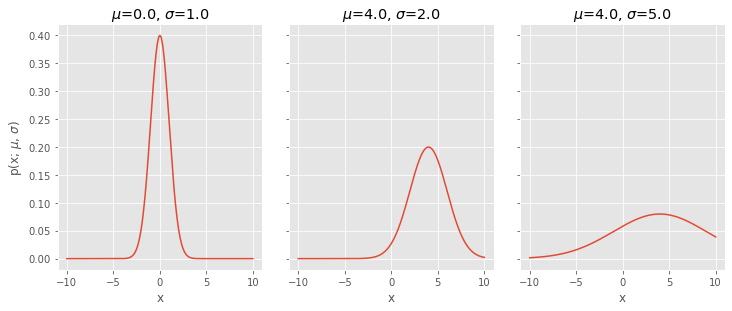

In [198]:
def plot_univariate_gaussian():
    _mus_and_simgas = [(0, 1), (4, 2), (4, 5)]

    # plotting utilities
    # create a figure with 1 rows and 3 columns with proper spacing
    fig, ax = plt.subplots(1,len(_mus_and_simgas), figsize=(10,4), sharey=True) #placeholders for 2 row x 2 columns images
    fig.tight_layout() # automatically adjusts spacing of subplots.
    x = np.linspace(-10, 10, 500) # generate 500 evenly placed values of x from -10 to 10
    for i in range(len(_mus_and_simgas)):
        mu, sigma = _mus_and_simgas[i]
        # Gaussian distribution with parameter (mu, sigma)
        ax[i].plot(x, gaussian_pdf(x, mu, sigma))
        ax[i].set_title(f'$\\mu$={mu:.1f}, $\\sigma$={sigma:.1f}')
        if i == 0:
            ax[i].set_ylabel('p(x; $\mu$, $\sigma$)')
        ax[i].set_xlabel('x')
    plt.show()

plot_univariate_gaussian()

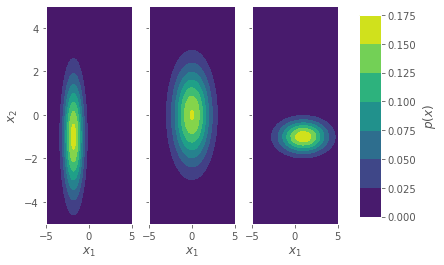

In [199]:
def plot_multivariate_gaussian():
    mu_0 = [-1.8, -1.0]
    mu_1 = [0.0, 0.0]
    mu_2 = [1.0, -1.0]
    Sigma_0 = [0.8, 1.8]
    Sigma_1 = [1.5, 1.5]
    Sigma_2 = [1.9, 0.5]
    # store the parameters in a list
    mus = np.array([mu_0, mu_1, mu_2])
    Sigmas = np.array([Sigma_0, Sigma_1, Sigma_2])

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    # build 2D grid
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)) 
    x = np.stack([x1, x2], axis=-1).reshape(10000, 2)
    for i, ax in enumerate(axes):
        z = gaussian_pdf(x, mus[i], Sigmas[i])
        img = ax.contourf(x1, x2, z.reshape(100, 100))
        ax.set_xlabel("$x_1$")
        if i == 0:
            ax.set_ylabel("$x_2$")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label("$p(x)$")
    plt.show()

plot_multivariate_gaussian()

### 2. Gaussian Naive Bayes Classifiers (NBCs)

#### 2.1 Overview

Naive Bayes classifiers are a kind of generative classifiers, which not only models the **class posterior distribution** $p(y|\boldsymbol{x};\boldsymbol{\theta})$ for prediction, but also models the **class conditional probability** $p(\boldsymbol{x}|y;\boldsymbol{\theta})$.

To clarify the **prior** and **posterior** distributions:
- the class **prior** distribution is denoted by $p(y;\boldsymbol{\pi})$; it encodes our prior belief about the class probalitiy $\pi$ without the knowledge of $\boldsymbol{x}$;
- the class **posterior** distribution is $p(y|\boldsymbol{x};\boldsymbol{\theta})$; it reflects our updated belief about the class probability after observing $\boldsymbol{x}$.

##### Formulation

The main idea of NBC models is to impose **conditional independence** on the class conditional probability density $p(\boldsymbol{x}|y;\boldsymbol{\theta})$. In other words, the feature dimensions are independent of each other conditional on the class variable $y$. Supposing $y=c$, we have 
$$
 p(\boldsymbol{x}|y=c;\boldsymbol{\theta}) = \prod_{d=1}^D p(x_{d}|y=c;\boldsymbol{\theta}_{dc}).
$$

##### Maximum Likelihood Estimation (MLE)

All data points in the dataset $D = \{(\boldsymbol{x}_n, y_n)\}_{n=1}^N$ are assumed i.i.d. (**independent** and identically distributed). If we denote $\boldsymbol{x}_{nd}$ as the $d$-th dimension of the $n$-th data point, this further means
$$
\begin{aligned}
p(D;\boldsymbol{\theta}) &= \prod_{n=1}^N p(\boldsymbol{x}_n, y_n|\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) p(\boldsymbol{x}_n|y_n;\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right).
\end{aligned}
$$

Fit the model via maximum likelihood estimation for the joint distribution over $x$ and $y$. The negative log likelihood (NLL) function is
$$
\begin{aligned}
-\log p(D;\boldsymbol{\theta}) &= -\log\prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right) \\
&= -\left(\sum_{n=1}^N \log p(y_n;\boldsymbol{\pi}) + \sum_{n=1}^N \log p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right)\right).
\end{aligned}
$$
The goal is to estimate $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$. Since the log likelihood functions involving $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$ are decoupled, we could estimate them individually via maximum likelihood estimation. In addition, they would typically have closed-form solutions, as we see below.

In this case, we have real-valued features ($x_d \in \mathbb{R}$ for each $d$). A suitable way is to model each feature dimension through a univariate Gaussian distribution $p(x_d|y=c;\boldsymbol{\theta}_{dc}) = \mathcal{N}(x_d|\mu_{dc}, \sigma^2_{dc})$.

Thus in the NBC model, there are three sets of parameters:
- $\boldsymbol{\pi}$: a $C$-dimensional vector, each dimension of which corresponds to the prior class probability. According to the lecture and textbook, this actually defines a categorical distribution and its parameter can be estimated as (denote $N_c$ as the number of data points for class $c$ and $N$ is the total number of data points)
$$
\widehat{\pi}_{c}=\frac{N_{c}}{N}.
$$
- $\boldsymbol{\mu}$: the mean of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional; for Gaussian distributions, it is known that the MLE for mean is
$$
\widehat{\mu}_{d c} =\frac{1}{N_{c}} \sum_{n: y_{n}=c} x_{n d}.
$$
- $\boldsymbol{\sigma}$: the standard deviation of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional. The MLE for the variance is
$$
\widehat{\sigma}_{d c}^{2} =\frac{1}{N_{c}} \sum_{n: y_{n}=c}\left(x_{n d}-\widehat{\mu}_{d c}\right)^{2}.
$$

#### **Implement Maximum Likelihood Estimation (MLE)**



In [200]:
# estimate parameter pi for prior class probability
def estimate_pi(y, num_classes):
    """
    Returns the prior class probability, pi, estimated from the data labels.

    y: y.shape == [N], where N is the number of data points.
    num_classes: the number of classes.

    return
    estimated_pi: estimated_pi.shape == [num_classes]
    """
    N = y.shape[0] # total number of data points
    estimated_pi = np.zeros(num_classes)
    for i in range(num_classes):
        estimated_pi[i] = np.sum(y == i) / N
    return estimated_pi

# estimate parameter theta = (mu, sigma) for class conditional probability
def estimate_theta(x, y, num_classes):
    """
    Returns the class conditional probability parameters, theta, estimated from the data.

    x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
    y: y.shape == [N], where N is the number of data points.
    num_classes: the number of classes.

    return
    estimated_mu: estimated_mu.shape == [num_classes, D]
    estimated_Sigma: estimated_Sigma.shape == [num_classes, D, D]
    """
    N, D = x.shape # N is the number of data points and D is the dimensionality of the data
    estimated_mu = np.zeros((num_classes, D))
    estimated_Sigma = np.zeros((num_classes, D, D))


    for classes in range(num_classes):
        x_c = x[y == classes]  
        estimated_mu[classes] = np.mean(x_c, axis=0)
        estimated_Sigma[classes] = np.diag(np.var(x_c, axis=0))
    return estimated_mu, estimated_Sigma


In [201]:
_estimated_pi = estimate_pi(y_train, num_classes)
_estimated_mu, _estimated_Sigma = estimate_theta(x_train, y_train, num_classes)

print("Estimated pi: {}".format(_estimated_pi))
for class_c in range(num_classes):
	print("=====> Class {}".format(class_c))
	estimated_mu_class_c = _estimated_mu[class_c].tolist()
	print("Estimated mu: {}".format(estimated_mu_class_c))

	estimated_Sigma_class_c = _estimated_Sigma[class_c].tolist()
	print("Estimated Sigma: {}".format(estimated_Sigma_class_c))

Estimated pi: [0.333 0.333 0.333]
=====> Class 0
Estimated mu: [4.9725, 3.4274999999999998, 1.4499999999999995, 0.24500000000000002]
Estimated Sigma: [[0.11949375000000002, 0.0, 0.0, 0.0], [0.0, 0.10099374999999997, 0.0, 0.0], [0.0, 0.0, 0.029999999999999992, 0.0], [0.0, 0.0, 0.0, 0.011975000000000001]]
=====> Class 1
Estimated mu: [5.892499999999998, 2.7425, 4.237499999999999, 1.305]
Estimated Sigma: [[0.29169374999999986, 0.0, 0.0, 0.0], [0.0, 0.09744375000000002, 0.0, 0.0], [0.0, 0.0, 0.24134375000000005, 0.0], [0.0, 0.0, 0.0, 0.038974999999999996]]
=====> Class 2
Estimated mu: [6.597499999999999, 3.0049999999999994, 5.552499999999999, 2.045]
Estimated Sigma: [[0.3987437500000003, 0.0, 0.0, 0.0], [0.0, 0.11247499999999999, 0.0, 0.0], [0.0, 0.0, 0.26499375, 0.0], [0.0, 0.0, 0.0, 0.07597499999999999]]


#### 2.2 Prediction

\begin{aligned}
p(y=c | \boldsymbol{x}; \boldsymbol{\theta}) &= \frac{p(\boldsymbol{x}, y=c;\boldsymbol{\theta})}{p(\boldsymbol{x};\boldsymbol{\theta})} \\
&= \frac{p(y=c;\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})}{\sum_{c'} p(y=c';\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})} \\
&= \frac{p(y=c ; \boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{d} | y=c; \boldsymbol{\theta}_{d c}\right)}{\sum_{c^{\prime}} p\left(y=c^{\prime} ; \boldsymbol{\pi}\right) \prod_{d=1}^{D} p\left(x_{d} | y=c^{\prime}; \boldsymbol{\theta}_{d c^{\prime}}\right)}.
\end{aligned}
$$


#### **Naive Bayes Classifier prediction**



In [202]:
class NaiveBayesClassifier(object):
    '''
    Naive Bayes Classifier

    '''
    def __init__(self, num_classes, D):
        self.num_classes = num_classes
        self.D = D
        # initialize the parameters
        self.pi = np.zeros(num_classes)
        self.mu = np.zeros((num_classes, D))
        self.sigma = np.zeros((num_classes, D))

    def fit(self, x, y):
        """
        Fit the model parameters from the data features and labels.

        x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
        y: y.shape == [N], where N is the number of data points.

        computes
        self.pi: self.pi.shape == [num_classes]
        self.mu: self.mu.shape == [num_classes, D]
        self.sigma: self.sigma.shape == [num_classes, D]
        """
        self.pi = estimate_pi(y, self.num_classes)
        self.mu, self.sigma = estimate_theta(x, y, self.num_classes)

    def predict(self, x):
        """    
        Predict the class labels for the input data features.

        x: x.shape == [M, D], where M is the number of test data points and D is the dimensionality of the data.

        returns
        y_pred: y_pred.shape == [M], the predicted labels for each data point. 
                It should be an integer in {0, 1, ..., num_classes-1}.

        NOTE: the estimated parameters are stored in self.pi, self.mu, and self.sigma, respectively.
        """
        num_test_points, _ = x.shape
        y_pred = np.zeros(num_test_points, dtype=int)

        for i in range(num_test_points):
            posterior_probs = np.zeros(self.num_classes)
            for classes in range(self.num_classes):
                class_probs = np.prod(
                    np.exp(-0.5 * np.square(x[i] - self.mu[classes]) / (self.sigma[classes] + 1e-9)) /
                    np.sqrt(2 * np.pi * (self.sigma[classes] + 1e-9))
                )
                posterior_probs[classes] = self.pi[classes] * class_probs

            y_pred[i] = np.argmax(posterior_probs)

        return y_pred


The accuracy is computed as follows:
$$
\text{accuracy} = \frac{\text{number of correctly classified data points}}{\text{total number of data points}}.
$$


In [203]:
def test_model(model):
    # call the `predict()` method to
    # predict the label for each test data point.
    y_predicted = model.predict(x_test)
    # compute the accuracy by comparing
    # the predicted labels with the ground truth labels.
    accuracy = np.sum(y_predicted == y_test) / y_test.shape[0]
    print("Accuracy: {:.2f}".format(accuracy))
    

In [204]:
# initialize the model with proper arguments
model = NaiveBayesClassifier(num_classes, D)
# train the model
model.fit(x_train,y_train)
# test the model using the same method as in logistic regression.
test_model(model)

Accuracy: 0.33


## Section 2: Multi-Layer Perceptron (MLP)

### **Build the MLP model and data loader (20 points)**

The model  have the following structure:
- Input layer: 4 neurons  # equal to the number of features
- Hidden layer 1: 20 neurons
- Hidden layer 2: 20 neurons
- Output layer: 3 neurons  # equal to the number of classes

The activation function for the hidden layers is ReLU, and the activation function for the output layer is log-softmax. The log-softmax function is defined as follows: 
$$
\text{log-softmax}(x_i) = \log \left(\frac{\exp(x_i)}{\sum_j \exp(x_j)}\right).
$$
The log-softmax function is a variant of the softmax function. It is used to convert the output of the output layer into a probability distribution over the classes. The log-softmax function is used instead of the softmax function because it is more numerically stable. The log-softmax function is also used instead of the softmax function because it is easier to compute the gradient of the log-softmax function than the gradient of the softmax function.

The MLP model should be able to take in a batch of data points and output the predicted class probabilities for each data point. The predicted class is the one with the highest probability.



In [205]:
class IrisMLP(nn.Module):
    def __init__(self, num_classes, D):
        super(IrisMLP, self).__init__()
        self.fc1 = nn.Linear(D, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, num_classes)


    def forward(self, x):

        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x

    
from torch.utils.data import Dataset, DataLoader
class IrisDataset(Dataset):
    """Iris dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: the features of the data points.
            y: the labels of the data points.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        """
        Returns the total number of data points.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns the data point corresponding to the index `idx`.
        """
        return self.X[idx], self.y[idx]
    
# constructing the dataloaders for later training and testing 
def get_dataloaders(batch_size):
    train_dataloader = DataLoader(IrisDataset(x_train, y_train), batch_size=batch_size)
    test_dataloader = DataLoader(IrisDataset(x_test, y_test), batch_size=batch_size)
    return train_dataloader, test_dataloader


### **Build the training pipeline**

#### Single epoch training and testing


In [206]:
# The training process for one epoch
def train_one_epoch(model, criterion, optimizer, train_dataloader, train_size):
    model.train()
    train_loss = 0. 
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # note that the loss function is averaged over all elements within the 
        # batch. Therefore, we compute the    
        train_loss += loss.item() * batch_size

    train_loss = train_loss / train_size  
    return train_loss

# Evaluate the model performance over the test data
def test_one_epoch(model, criterion, test_dataloader, test_size):
    # overall accuracy of the model
    correct = 0
    test_loss = 0.
    model.eval()

    with torch.no_grad():
        for x, y in test_dataloader:
            batch_size = x.shape[0]
            x, y = x.to(device), y.to(device)
            # calculate outputs by running images through the network
            log_prob = model(x)

            # calculate Cross Entropy loss   
            # no backprop here!
            loss = criterion(log_prob, y)
        
            # the class with the highest log prob is what we choose as prediction
            predicted = torch.argmax(log_prob, dim=1)

            test_loss += loss.item() * batch_size

            correct += (predicted == y).sum().item()
    test_loss = test_loss / test_size
    test_acc = 100 * correct / test_size
    return test_loss, test_acc


#### Training and testing

In [215]:
num_features = 4
num_classes = 3
epochs = 20 
batch_size = 30


model = IrisMLP(num_classes, num_features)
train_dataloader, test_dataloader = get_dataloaders(batch_size)
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # use Adam optimizer
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1): 
    train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, train_size)
    test_loss, test_acc = test_one_epoch(model, criterion, test_dataloader, test_size)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        'Epoch: [{:4d}] | * training loss : {:.3f} | o testing loss : {:.3f} | + testing acc. {:.2f} %'
        .format(epoch, train_loss, test_loss, test_acc))

Epoch: [   1] | * training loss : 1.710 | o testing loss : 1.134 | + testing acc. 33.33 %
Epoch: [   2] | * training loss : 1.284 | o testing loss : 1.040 | + testing acc. 33.33 %
Epoch: [   3] | * training loss : 1.051 | o testing loss : 0.933 | + testing acc. 33.33 %
Epoch: [   4] | * training loss : 0.956 | o testing loss : 0.855 | + testing acc. 66.67 %
Epoch: [   5] | * training loss : 0.870 | o testing loss : 0.762 | + testing acc. 66.67 %
Epoch: [   6] | * training loss : 0.752 | o testing loss : 0.682 | + testing acc. 66.67 %
Epoch: [   7] | * training loss : 0.724 | o testing loss : 0.620 | + testing acc. 66.67 %
Epoch: [   8] | * training loss : 0.668 | o testing loss : 0.562 | + testing acc. 90.00 %
Epoch: [   9] | * training loss : 0.578 | o testing loss : 0.494 | + testing acc. 70.00 %
Epoch: [  10] | * training loss : 0.529 | o testing loss : 0.428 | + testing acc. 83.33 %
Epoch: [  11] | * training loss : 0.462 | o testing loss : 0.379 | + testing acc. 86.67 %
Epoch: [  